In [1]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import gc

In [2]:
from sklearn.metrics import roc_curve 
def score(y,pred): 
    fpr, tpr, thresholds = roc_curve(y, pred, pos_label=1) 
    score=0.4*tpr[np.where(fpr>=0.001)[0][0]]+0.3*tpr[np.where(fpr>=0.005)[0][0]]+0.3*tpr[np.where(fpr>=0.01)[0][0]] 
    return score 

In [17]:
def model(features, test_features, n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
        # Extract the ids
    train_ids = features['id']
    test_ids = test_features['id']
    
    # Extract the labels for training
    labels = features['label']
    
    # Remove the ids and target
    features = features.drop(columns = ['id', 'label'])
    test_features = test_features.drop(columns = ['id'])
    
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
        # Extract feature names
    feature_names = list(features.columns)
        # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
        # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
        # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
        # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
        # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
        # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced',
                                   learning_rate = 0.02, 
#                                    reg_alpha = 0.1, 
#                                    reg_lambda = 0.1, 
#                                    subsample = 0.8, 
                                   n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], 
                  early_stopping_rounds = 20, 
                  verbose = 200)
            # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
                # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
                # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
                # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
                # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'id': test_ids, 'score': test_predictions})
        # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
        # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
        # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
        # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    val_score = score(labels, out_of_fold)
    valid_scores.append(val_score)
    train_scores.append(np.mean(train_scores))
    fold_names.append('score')
        # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    return submission, feature_importances, metrics
    

In [18]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    return df

In [5]:
df_train = pd.read_csv("../transdata/train_impute_v2.csv",header=0,index_col=None)
df_train.sort_values(by='date', ascending=True, inplace=True)
df_train=df_train.iloc[500000:,]
df_train.drop(labels=["date"],axis=1,inplace=True)
df_test = pd.read_csv("../transdata/test_impute_v2.csv", header=0, index_col=None)
df_test.drop(labels=["date"], axis=1, inplace=True)

In [10]:
df_train_1 = df_train.loc[df_train["label"]==1]
print("the shape of df_train_1 is ", df_train_1.shape)


the shape of df_train_1 is  (8269, 263)


In [11]:
df_train_0 = df_train.loc[df_train["label"]==0]
print("the shape of df_train_0 is ", df_train_0.shape)

the shape of df_train_0 is  (486462, 263)


the 0th iteration
0    82690
1     8269
Name: label, dtype: int64
Training Data Shape:  (90959, 261)
Testing Data Shape:  (500538, 261)
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[9]	valid's auc: 0.498631	train's auc: 0.598106
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.506231	train's auc: 0.536933
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[4]	valid's auc: 0.504587	train's auc: 0.596128
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[5]	valid's auc: 0.51556	train's auc: 0.575124
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[3]	valid's auc: 0.517102	train's auc: 0.573627
Baseline metrics
      fold     train     valid
0        0  0.598106  0.498631
1        1  0.536933  0.506231
2        2  0.596128  0.504587

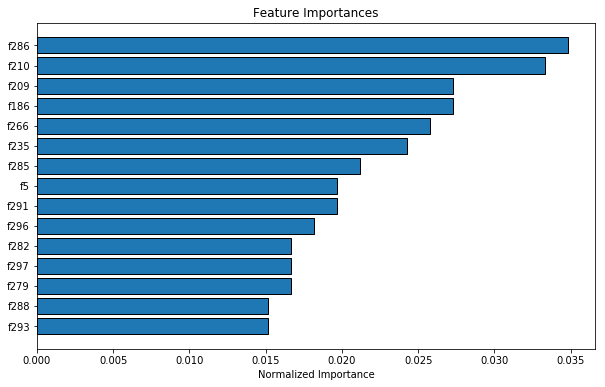

144
the 1th iteration
0    82690
1     8269
Name: label, dtype: int64
Training Data Shape:  (90959, 144)
Testing Data Shape:  (500538, 144)
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.507785	train's auc: 0.536241
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[9]	valid's auc: 0.50209	train's auc: 0.566628
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[7]	valid's auc: 0.506825	train's auc: 0.568096
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[27]	valid's auc: 0.49863	train's auc: 0.636579
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[12]	valid's auc: 0.499345	train's auc: 0.586699
Baseline metrics
      fold     train     valid
0        0  0.536241  0.507785
1        1  0.566628  0.502090
2        2  0.568096  0.5

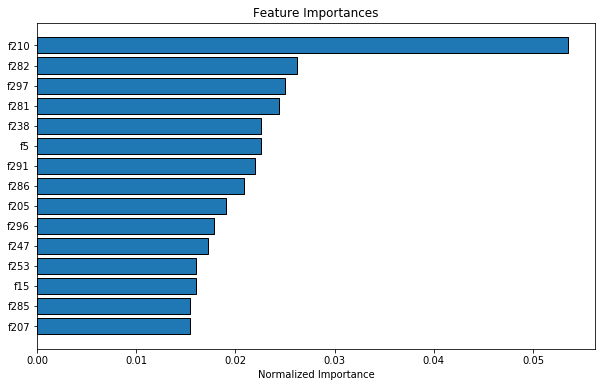

139
the 2th iteration
0    82690
1     8269
Name: label, dtype: int64
Training Data Shape:  (90959, 139)
Testing Data Shape:  (500538, 139)
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.505215	train's auc: 0.525151
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[39]	valid's auc: 0.505671	train's auc: 0.690629
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[7]	valid's auc: 0.503898	train's auc: 0.592575
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[15]	valid's auc: 0.507093	train's auc: 0.585656
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[14]	valid's auc: 0.509571	train's auc: 0.602159
Baseline metrics
      fold     train     valid
0        0  0.525151  0.505215
1        1  0.690629  0.505671
2        2  0.592575  

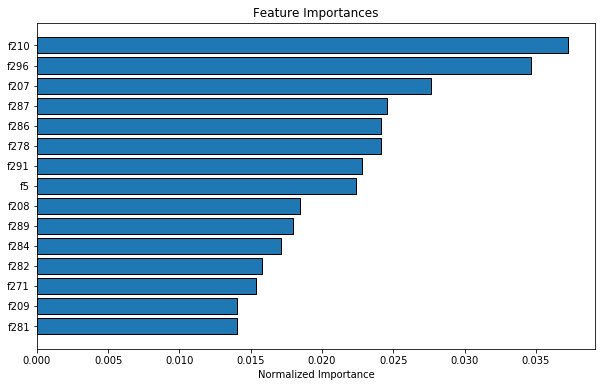

136
the 3th iteration
0    82690
1     8269
Name: label, dtype: int64
Training Data Shape:  (90959, 136)
Testing Data Shape:  (500538, 136)
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[9]	valid's auc: 0.500602	train's auc: 0.570118
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[2]	valid's auc: 0.499442	train's auc: 0.549792
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[7]	valid's auc: 0.516315	train's auc: 0.592239
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[8]	valid's auc: 0.49972	train's auc: 0.569453
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.504095	train's auc: 0.534715
Baseline metrics
      fold     train     valid
0        0  0.570118  0.500602
1        1  0.549792  0.499442
2        2  0.592239  0.51

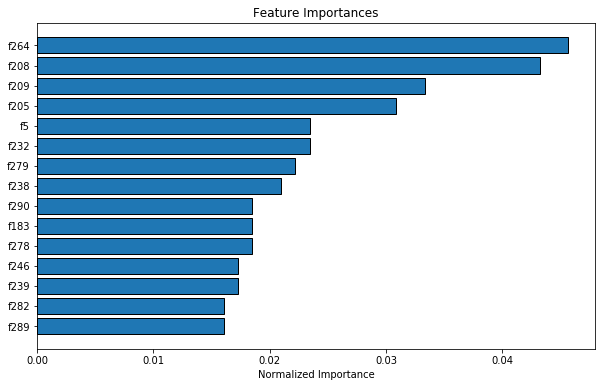

123
the 4th iteration
0    82690
1     8269
Name: label, dtype: int64
Training Data Shape:  (90959, 123)
Testing Data Shape:  (500538, 123)
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[3]	valid's auc: 0.508787	train's auc: 0.55874
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[3]	valid's auc: 0.507216	train's auc: 0.562559
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[12]	valid's auc: 0.499998	train's auc: 0.621802
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[6]	valid's auc: 0.509806	train's auc: 0.566749
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[10]	valid's auc: 0.523007	train's auc: 0.612672
Baseline metrics
      fold     train     valid
0        0  0.558740  0.508787
1        1  0.562559  0.507216
2        2  0.621802  0.

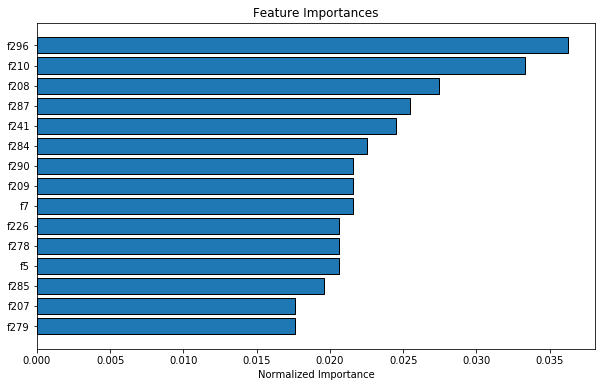

116
the 5th iteration
0    82690
1     8269
Name: label, dtype: int64
Training Data Shape:  (90959, 116)
Testing Data Shape:  (500538, 116)
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.496773	train's auc: 0.537767
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.503619	train's auc: 0.540685
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[2]	valid's auc: 0.508171	train's auc: 0.536424
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[28]	valid's auc: 0.497735	train's auc: 0.646026
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[14]	valid's auc: 0.495213	train's auc: 0.616622
Baseline metrics
      fold     train     valid
0        0  0.537767  0.496773
1        1  0.540685  0.503619
2        2  0.536424  0

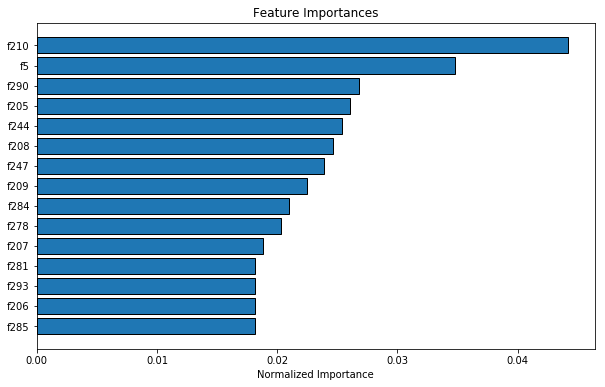

112
the 6th iteration
0    82690
1     8269
Name: label, dtype: int64
Training Data Shape:  (90959, 112)
Testing Data Shape:  (500538, 112)
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.500149	train's auc: 0.543524
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[42]	valid's auc: 0.502793	train's auc: 0.666812
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[19]	valid's auc: 0.503961	train's auc: 0.603983
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[14]	valid's auc: 0.506135	train's auc: 0.591688
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.504986	train's auc: 0.537642
Baseline metrics
      fold     train     valid
0        0  0.543524  0.500149
1        1  0.666812  0.502793
2        2  0.603983  

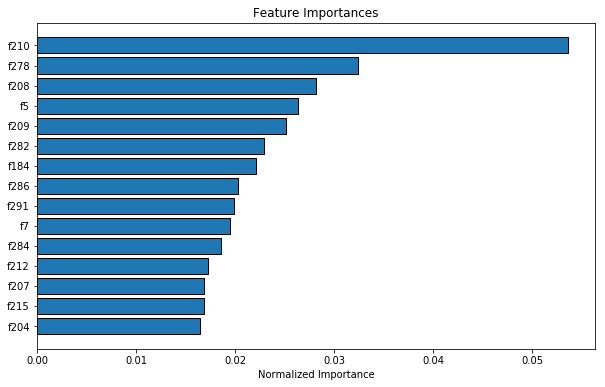

112
the 7th iteration
0    82690
1     8269
Name: label, dtype: int64
Training Data Shape:  (90959, 112)
Testing Data Shape:  (500538, 112)
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.500889	train's auc: 0.527879
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[4]	valid's auc: 0.50695	train's auc: 0.57869
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.50517	train's auc: 0.542901
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.492688	train's auc: 0.545409
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[19]	valid's auc: 0.510514	train's auc: 0.617192
Baseline metrics
      fold     train     valid
0        0  0.527879  0.500889
1        1  0.578690  0.506950
2        2  0.542901  0.505

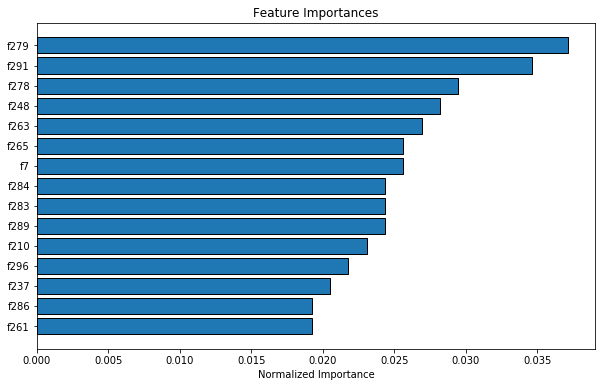

108
the 8th iteration
0    82690
1     8269
Name: label, dtype: int64
Training Data Shape:  (90959, 108)
Testing Data Shape:  (500538, 108)
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[12]	valid's auc: 0.49918	train's auc: 0.601603
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[8]	valid's auc: 0.514176	train's auc: 0.588151
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[12]	valid's auc: 0.500628	train's auc: 0.602268
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[4]	valid's auc: 0.492216	train's auc: 0.573251
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[4]	valid's auc: 0.500262	train's auc: 0.560181
Baseline metrics
      fold     train     valid
0        0  0.601603  0.499180
1        1  0.588151  0.514176
2        2  0.602268  0.

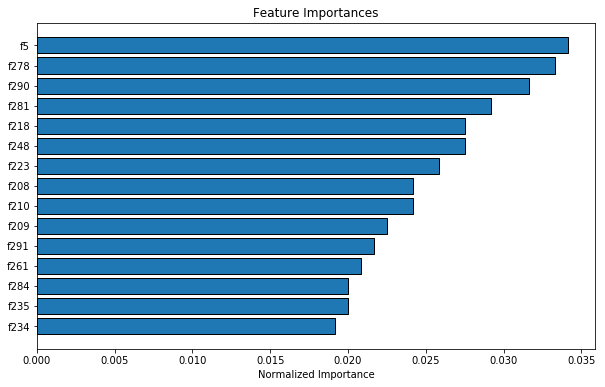

104
the 9th iteration
0    82690
1     8269
Name: label, dtype: int64
Training Data Shape:  (90959, 104)
Testing Data Shape:  (500538, 104)
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[5]	valid's auc: 0.511433	train's auc: 0.552822
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[39]	valid's auc: 0.49954	train's auc: 0.660331
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[3]	valid's auc: 0.498707	train's auc: 0.558525
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.500332	train's auc: 0.526471
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[5]	valid's auc: 0.495071	train's auc: 0.571585
Baseline metrics
      fold     train     valid
0        0  0.552822  0.511433
1        1  0.660331  0.499540
2        2  0.558525  0.4

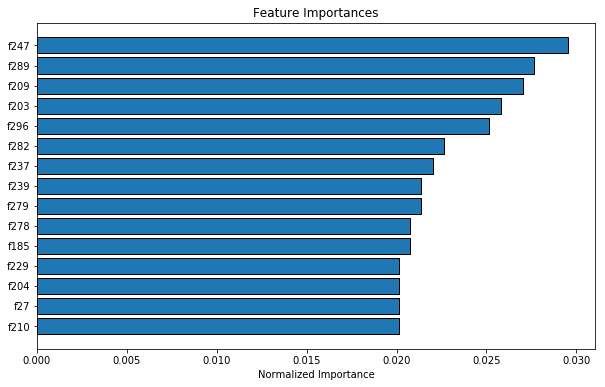

104
the 10th iteration
0    82690
1     8269
Name: label, dtype: int64
Training Data Shape:  (90959, 104)
Testing Data Shape:  (500538, 104)
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[12]	valid's auc: 0.515361	train's auc: 0.583668
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[19]	valid's auc: 0.521145	train's auc: 0.63585
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.516373	train's auc: 0.546102
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[27]	valid's auc: 0.507698	train's auc: 0.602387
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[5]	valid's auc: 0.521975	train's auc: 0.54842
Baseline metrics
      fold     train     valid
0        0  0.583668  0.515361
1        1  0.635850  0.521145
2        2  0.546102  0

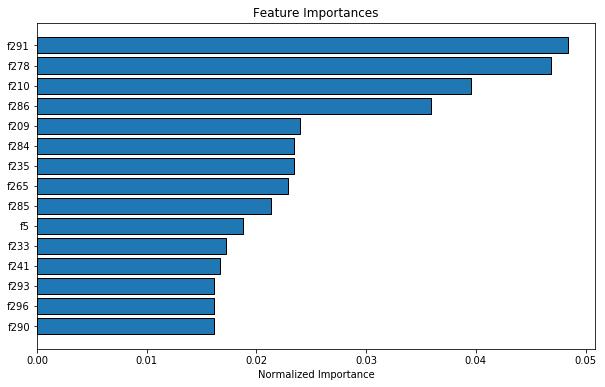

104


In [19]:
import random
sample_1_len = len(df_train_1)*10
keep_feature = list(set(df_train_1)-set(["id","label"]))
submission_overall= pd.DataFrame()
for i in range(11):
    print("the {}th iteration".format(i))
    df_train_0_sample = df_train_0.sample(n=sample_1_len,random_state=random.randint(0,100)).reset_index(drop=True)
    df_train_sample = pd.concat([df_train_0_sample,df_train_1],axis=0).reset_index(drop=True).sample(frac=1.0)
    print(df_train_sample["label"].value_counts())
    submission, fi, metrics = model(df_train_sample[keep_feature+["id","label"]], df_test[keep_feature+["id"]])
    print('Baseline metrics')
    print(metrics)
    fi_sorted = plot_feature_importances(fi)
    keep_feature = fi_sorted.loc[fi_sorted["importance"]>0.0]["feature"].tolist()
    print(len(keep_feature))
    if i ==0:
        submission_overall=submission
    else:
        submission_overall["score"] = submission_overall["score"].add(submission["score"],fill_value=0)

    

In [20]:
submission_overall["score"] = submission_overall["score"]/11

In [21]:
submission_overall.to_csv('../result/2018-07-08/baseline_lgb.csv', index = False)

In [23]:
ds1 = df_train_0.describe()
print(ds1)
ds1.to_csv("../statsfile/stats2.csv",mode="a")
ds2 = df_train_1.describe()
print(ds2)
ds2.to_csv("../statsfile/stats2.csv",mode="a")

          label             f1             f2             f3             f4  \
count  486462.0  486462.000000  486462.000000  486462.000000  486462.000000   
mean        0.0       0.725633       0.500793       0.700932       0.523708   
std         0.0       0.651554       0.500345       0.640983       0.522483   
min         0.0       0.000000       0.000000       0.000000       0.000000   
25%         0.0       0.000000       0.000000       0.000000       0.000000   
50%         0.0       1.000000       1.000000       1.000000       1.000000   
75%         0.0       1.000000       1.000000       1.000000       1.000000   
max         0.0       2.000000       2.000000       2.000000       2.000000   

                  f6             f7             f8            f9  \
count  486462.000000  486462.000000  486462.000000  486462.00000   
mean        0.691287       4.263451       1.409335       0.58663   
std         0.729237       1.908695       0.576486       0.57367   
min         0.00